In [2]:
import pandas as pd
import pickle
%config Completer.use_jedi = False

goal_set = pickle.load(open('../synthetic_dataset/goal_set.p', 'rb'))
slot_set = pickle.load(open('../synthetic_dataset/slot_set.p', 'rb'))


In [3]:
lengths = {key: len(value) for key, value in goal_set.items()}
lengths

{'train': 24000, 'test': 6000, 'validate': 0}

In [4]:
train_data = goal_set['train']
test_data = goal_set['test']

In [7]:
# test 데이터에는 새로운 질병이나 증상이 없음을 확안

train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)

train_diseases = set(train_df['disease_tag'].unique())
train_symptoms = set()

unique_diseases = train_df['disease_tag'].nunique()

explicit_symptoms = set()
implicit_symptoms = set()

for index, row in train_df.iterrows():
    explicit_symptoms.update(row['goal']['explicit_inform_slots'].keys())
    implicit_symptoms.update(row['goal']['implicit_inform_slots'].keys())

print("유니크한 질병 갯수:", unique_diseases)
print("유니크한 명시적 증상 갯수:", len(explicit_symptoms))
print("유니크한 암묵적 증상 갯수:", len(implicit_symptoms))

overlapping_symptoms = explicit_symptoms.intersection(implicit_symptoms)
total_symptoms = explicit_symptoms.union(implicit_symptoms)

print("명시적, 암묵적 증상에 둘다 있는 증상 갯수:", len(overlapping_symptoms))
print("명시적, 암묵적 증상중 하나라도 있는 증상 갯수:", len(total_symptoms))

유니크한 질병 갯수: 90
유니크한 명시적 증상 갯수: 265
유니크한 암묵적 증상 갯수: 264
명시적, 암묵적 증상에 둘다 있는 증상 갯수: 263
명시적, 암묵적 증상중 하나라도 있는 증상 갯수: 266


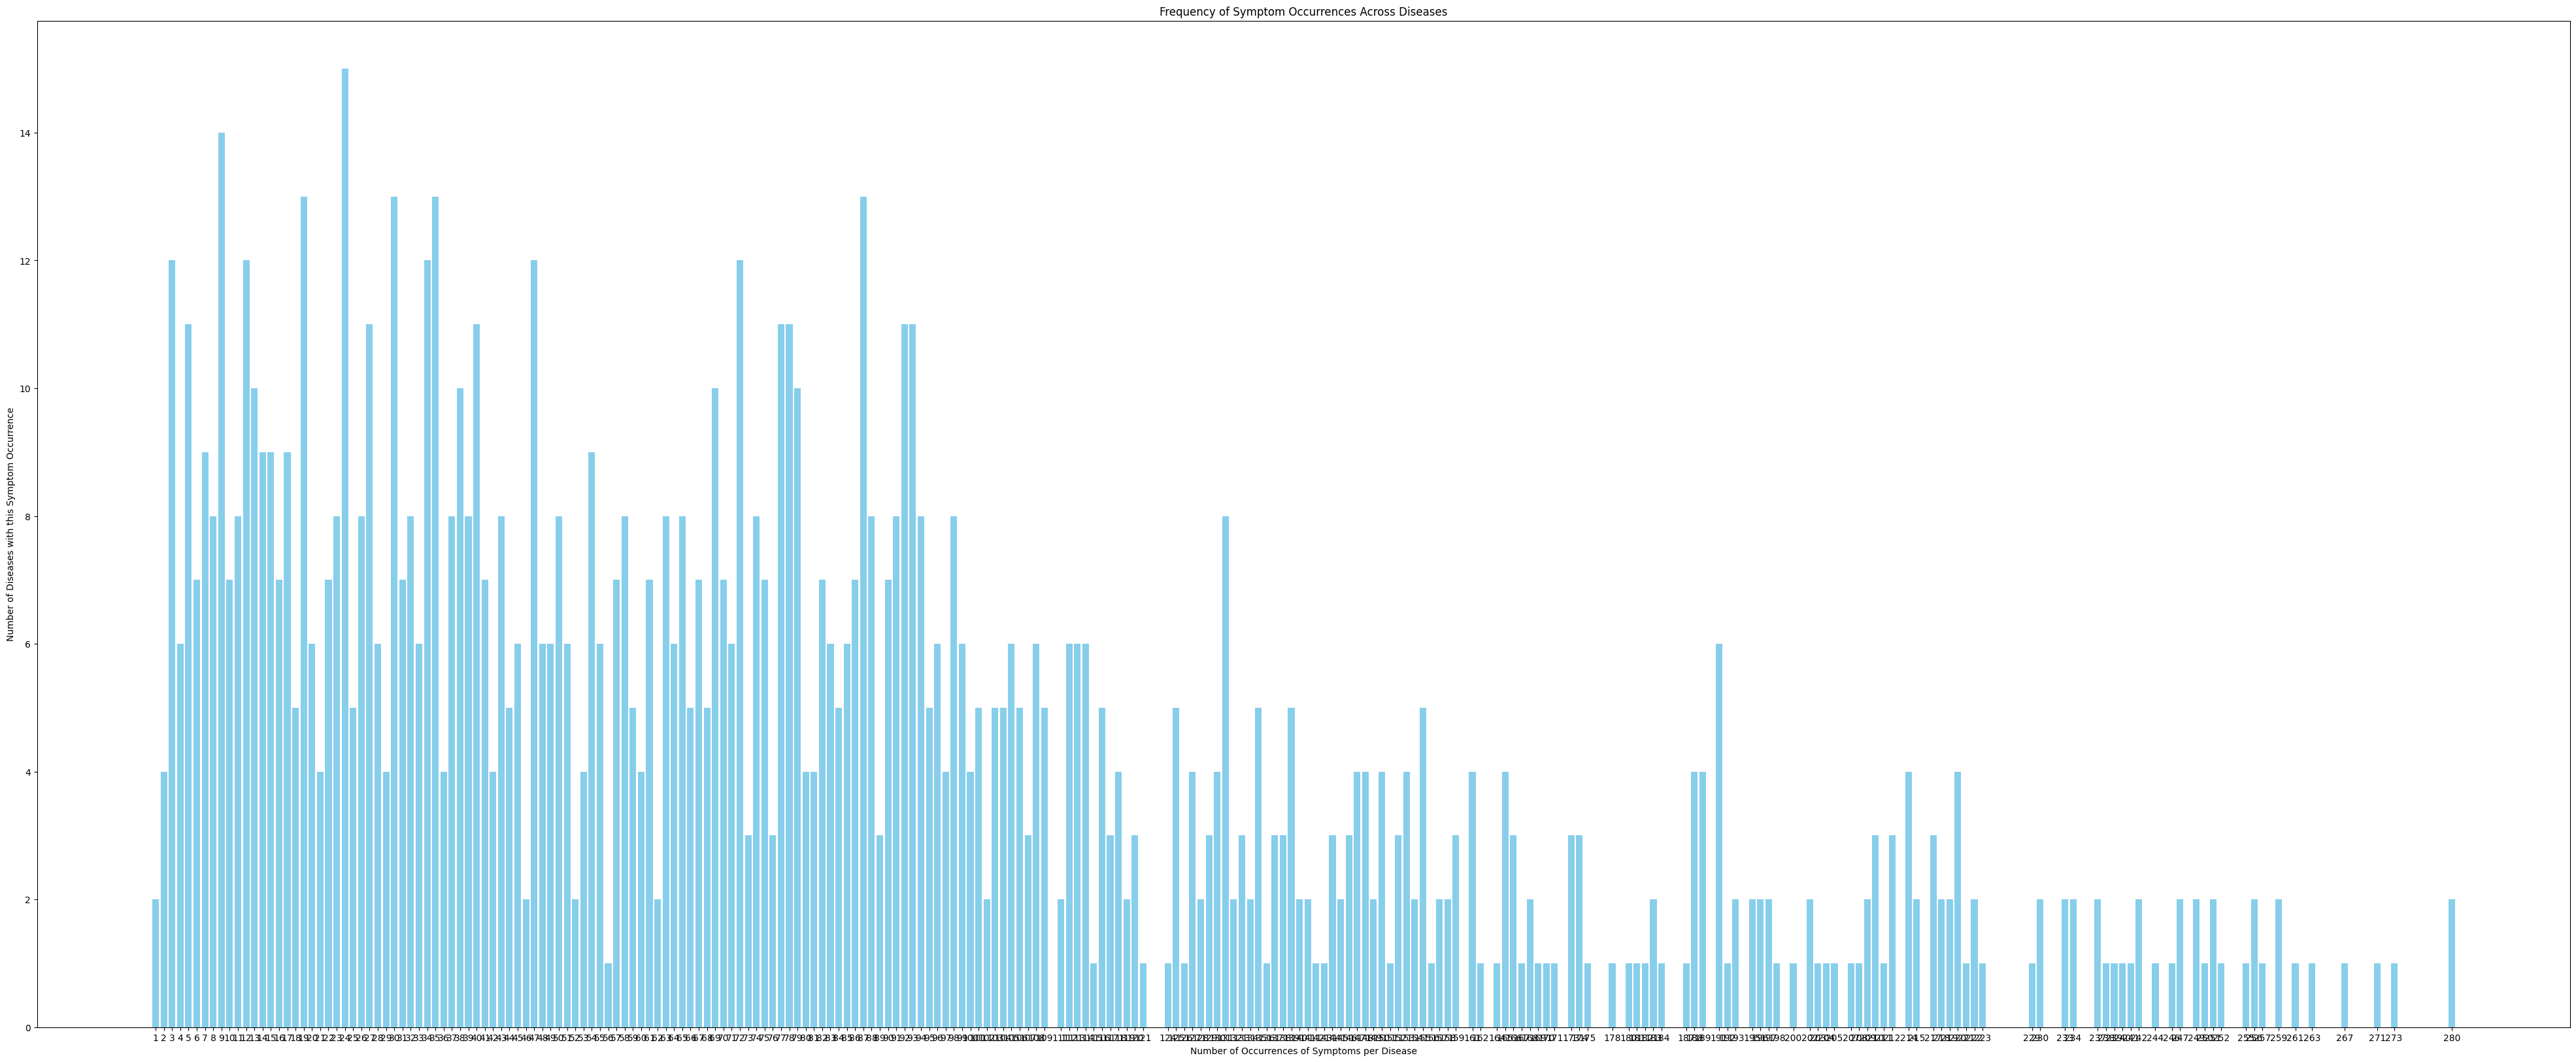

In [6]:
# 질병마다 각 증상이 몇 번 나타나는지를 측정하고, 전체 데이터셋에서 각각의 증상 발생 횟수가 몇 개의 질병에서 나타나는지를 파악
# 하나의 질병에 대해서 특정 증상이 몇번이나 반복해서 나타나는지 통계 데이터
# 만약 모두 비슷한 횟수를 가지고 있다면 증상의 빈도가 중요한 데이터가 아닐것.
import matplotlib.pyplot as plt
from collections import Counter

disease_data = {}

for index, row in train_df.iterrows():
    disease = row['disease_tag']
    symptoms_list = list(row['goal']['explicit_inform_slots'].keys()) + list(row['goal']['implicit_inform_slots'].keys())
    if disease not in disease_data:
        disease_data[disease] = Counter(symptoms_list)
    else:
        disease_data[disease].update(symptoms_list)

# 각 증상 발생 횟수가 몇 개의 질병에서 나타나는지 집계
symptom_occurrence = Counter()

for disease, symptoms in disease_data.items():
    for symptom, count in symptoms.items():
        symptom_occurrence[count] += 1

# 데이터 프레임 생성
occurrence_df = pd.DataFrame(list(symptom_occurrence.items()), columns=['Symptom Occurrences', 'Number of Diseases'])
occurrence_df.sort_values(by='Symptom Occurrences', inplace=True)

# 시각화
plt.figure(figsize=(50, 20))
plt.bar(occurrence_df['Symptom Occurrences'], occurrence_df['Number of Diseases'], color='skyblue')
plt.title('Frequency of Symptom Occurrences Across Diseases')
plt.xlabel('Number of Occurrences of Symptoms per Disease')
plt.ylabel('Number of Diseases with this Symptom Occurrence')
plt.xticks(occurrence_df['Symptom Occurrences'])
plt.grid(False)
plt.show()

In [6]:
from collections import Counter, defaultdict
from pprint import pprint


# 질병별 증상 빈도 데이터를 DataFrame으로 변환
disease_df = pd.DataFrame([(disease, symptom, count) for disease, symptoms in disease_data.items() for symptom, count in symptoms.items()], columns=['Disease', 'Symptom', 'Count'])
# 2개 이상의 질병에서 발생한 증상 리스트
all_symptoms = set(disease_df['Symptom'])
common_symptoms = set()
for symptom in all_symptoms:
    # 해당 증상을 가진 질병들
    # 증상을 기준으로 필터링하고 그 필터링된 행에서 질병을 unique()한게 2개 이상이면 2개 이상의 질병에 발생한 질병이라는 의미
    diseases_with_symptom = disease_df[disease_df['Symptom'] == symptom]['Disease'].unique()
    if len(diseases_with_symptom) >= 2:
        common_symptoms.add(symptom)

      
# 각 증상이 해당 질병에 유니크한지 여부를 표시
disease_df['Unique'] = disease_df['Symptom'].apply(lambda x: x not in common_symptoms)

# 증상을 '유니크' 여부와 '빈도'에 따라 정렬
disease_df.sort_values(by=['Disease', 'Unique', 'Count'], ascending=[True, False, False], inplace=True)
disease_df.head(15)

final_symptom_data = []
for disease, group in disease_df.groupby('Disease'):
    symptoms_list = [
        {'name': row['Symptom'], 'unique': bool(row['Unique']), 'count': int(row['Count'])}
        for _, row in group.iterrows()
    ]
    final_symptom_data.append({'disease': disease, 'symptoms': symptoms_list})

# 정렬
final_symptom_data = []
for disease, group in disease_df.groupby('Disease'):
    symptoms_list = [
        {'name': row['Symptom'], 'unique': bool(row['Unique']), 'count': int(row['Count'])}
        for _, row in group.iterrows()
    ]
    final_symptom_data.append({'disease': disease, 'symptoms': symptoms_list})

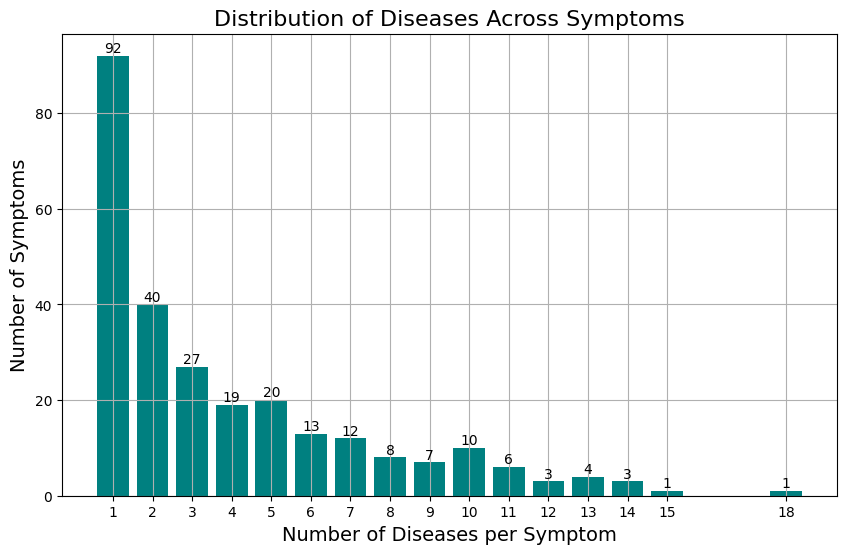

In [7]:
import matplotlib.pyplot as plt
from collections import defaultdict
# 증상-질병 매핑
symptom_to_diseases = defaultdict(set)
for entry in train_data:
    disease = entry['disease_tag']
    all_symptoms = list(entry['goal']['explicit_inform_slots'].keys()) + list(entry['goal']['implicit_inform_slots'].keys())
    for symptom in all_symptoms:
        symptom_to_diseases[symptom].add(disease)



# 변환된 사전을 리스트로 변환
symptom_disease_list = [{'symptom': symptom, 'diseases': list(diseases)} for symptom, diseases in symptom_to_diseases.items()]


# # 증상별 질병 수 계산
symptom_counts = {item['symptom']: len(item['diseases']) for item in symptom_disease_list}
symptom_df = pd.DataFrame(list(symptom_counts.items()), columns=['Symptom', 'Number of Diseases'])

# # 증상별 질병 수에 따른 질병의 수 계산 (증상 분포)
disease_count_frequency = symptom_df['Number of Diseases'].value_counts().reset_index()
disease_count_frequency.columns = ['Number of Diseases', 'Frequency']
disease_count_frequency = disease_count_frequency.sort_values(by='Number of Diseases')

# # 히스토그램 그리기
plt.figure(figsize=(10, 6))
bars = plt.bar(disease_count_frequency['Number of Diseases'], disease_count_frequency['Frequency'], color='teal')

# 각 막대에 숫자 추가
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, yval, ha='center', va='bottom', fontsize=10)
    
plt.xlabel('Number of Diseases per Symptom', fontsize=14)
plt.ylabel('Number of Symptoms', fontsize=14)
plt.title('Distribution of Diseases Across Symptoms', fontsize=16)
plt.xticks(disease_count_frequency['Number of Diseases'])
plt.grid(True)
plt.show()

# 데이터를 보니 266개의 증상중 132개 즉 절반정도가 1~2개의 질병에만 있는 증상임.
# unique함의 정도가 정확도에 영향을 줄 수 있는 데이터라는것을 의미한다고 생각

In [11]:
train_df['All_Symptoms'] = train_df.apply(lambda x: list(x['goal']['explicit_inform_slots'].keys()) + list(x['goal']['implicit_inform_slots'].keys()), axis=1)
symptoms_expanded = train_df.explode('All_Symptoms')
symptoms_expanded = symptoms_expanded.rename(columns={'All_Symptoms': 'Symptoms'})
symptoms_expanded = symptoms_expanded[['disease_tag', 'Symptoms']]
symptoms_expanded['Count'] = 1
symptoms_expanded

,disease_tag,Symptoms,Count
0,Central retinal artery or vein occlusion,Spots or clouds in vision,1
0,Central retinal artery or vein occlusion,Diminished vision,1
0,Central retinal artery or vein occlusion,Symptoms of eye,1
0,Central retinal artery or vein occlusion,Pain in eye,1
1,Degenerative disc disease,Shoulder pain,1
...,...,...,...
23998,Dengue fever,Pain during pregnancy,1
23998,Dengue fever,Facial pain,1
23999,Flat feet,Knee pain,1
23999,Flat feet,Foot or toe pain,1


In [10]:
# 질병별 증상 데이터를 불리언 형태로 변환 (이진화)
symptoms_expanded_sample = symptoms_expanded.head(2000)
symptoms_binary = pd.pivot_table(symptoms_expanded_sample, values='Count', index='disease_tag', 
                                 columns='Symptoms', aggfunc='max', fill_value=0)
symptoms_binary = symptoms_binary.applymap(bool)
symptoms_binary

Symptoms,Abnormal appearing skin,Abnormal involuntary movements,Abnormal movement of eyelid,Absence of menstruation,Abusing alcohol,Ache all over,Acne or pimples,Allergic reaction,Ankle pain,Ankle stiffness or tightness,...,Vaginal pain,Vomiting,Vulvar sore,Warts,Weakness,Weight gain,White discharge from eye,Wrist lump or mass,Wrist pain,Wrist swelling
disease_tag,,,,,,,,,,,,,,,,,,,,,
Acanthosis nigricans,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,True,False,False,False,False
Acariasis,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Acne,True,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Actinic keratosis,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Acute glaucoma,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Gonorrhea,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
Gout,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
Granuloma inguinale,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False


In [11]:
from mlxtend.frequent_patterns import apriori, association_rules
# 연관 규칙 학습 (Association Rule Learning)
# Apriori 알고리즘 적용: 최소 and 지지도 설정
frequent_itemsets = apriori(symptoms_binary, min_support=0.01, use_colnames=True)

# 연관 규칙 생성: 최소 신뢰도 설정
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)
# print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

top_rules = rules.nlargest(20, 'lift')  # confidence 기준으로 상위 20개 선택
print(top_rules[['antecedents', 'consequents', 'confidence', 'lift']])

                           antecedents                        consequents  \
196          (Infrequent menstruation)          (Absence of menstruation)   
197          (Absence of menstruation)          (Infrequent menstruation)   
200                    (Mass on vulva)          (Absence of menstruation)   
201          (Absence of menstruation)                    (Mass on vulva)   
478  (Shoulder stiffness or tightness)     (Ankle stiffness or tightness)   
479     (Ankle stiffness or tightness)  (Shoulder stiffness or tightness)   
480               (Stiffness all over)     (Ankle stiffness or tightness)   
481     (Ankle stiffness or tightness)               (Stiffness all over)   
560                            (Apnea)                    (Unwanted hair)   
561                    (Unwanted hair)                            (Apnea)   
566                 (Arm lump or mass)                     (Arm swelling)   
567                     (Arm swelling)                 (Arm lump or mass)   

In [ ]:
# Antecedents (전제): 규칙에서의 조건부 증상 집합.
# Consequents (결과): 규칙에서 예측되는 결과 증상 집합.
# Support: 전체 트랜잭션 중 Antecedents와 Consequents가 함께 발생하는 비율.
# Confidence: Antecedents가 주어졌을 때 Consequents도 함께 나타날 조건부 확률.
# Lift: Antecedents와 Consequents의 독립적인 출현 확률 대비 함께 나타날 확률의 배율. Lift 값이 1을 초과하면 두 항목의 출현이 서로 관련이 있음을 의미합니다.